### 1. Start the Environment

In [1]:
from mlagents.envs import UnityEnvironment
import numpy as np

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Reacher Unity environment.

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
# load Unity environment for Linux
env = UnityEnvironment(file_name='unity_envs/Reacher_Linux/Reacher_Linux.x86_64')

# # load Unity env for macos
# env = UnityEnvironment(file_name='unity_envs/Reacher_macos/Reacher.app')

INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherLearning
        Number of Visual Observations (per agent): 0
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): [4]
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

* Set-up: Double-jointed arm which can move to target locations.
* Goal: The agents must move its hand to the goal location, and keep it there.
* Agents: The environment contains 10 agent linked to a single Brain.
* Agent Reward Function (independent):
  * +0.1 Each step agent's hand is in goal location.
* Brains: One Brain with the following observation/action space.
  * Vector Observation space: 26 variables corresponding to position, rotation,
    velocity, and angular velocities of the two arm Rigidbodies.
  * Vector Action space: (Continuous) Size of 4, corresponding to torque
    applicable to two joints.
  * Visual Observations: None.
* Reset Parameters: Two, corresponding to goal size, and goal movement speed.
* Benchmark Mean Reward: 30

Lets print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size[0]
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In [5]:
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents) # initialize the score (for each agent)
step=0
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    step+=1
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.17549999607726932


### 4. Training the agent!

Now it's turn to train an agent to solve the environment!  When training the environment, we have to set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
import random
import datetime
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# defining the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("using",device)

using cuda:0


### 3. Define policy network (Actor Critic style)

In [8]:
state_size = brain.vector_observation_space_size
action_size = brain.vector_action_space_size
action_low = -1
action_high = 1

# define actor critic network
class ActorCritic(nn.Module):
    
    def __init__(self,state_size,action_size,action_high,action_low,hidden_sizes=[512,256]):
        super(ActorCritic, self).__init__()
        
        # action range
        self.action_high = torch.tensor(action_high).to(device)
        self.action_low = torch.tensor(action_low).to(device)
        
        self.std = nn.Parameter(torch.zeros(action_size))
        
        # common network
        self.fc1 = nn.Linear(state_size,hidden_sizes[0])
        
        # actor network
        self.fc2_actor = nn.Linear(hidden_sizes[0],hidden_sizes[1])
        self.fc3_action = nn.Linear(hidden_sizes[1],action_size)
        
        # critic network
        self.fc2_critic = nn.Linear(hidden_sizes[0],hidden_sizes[1])
        self.fc3_critic = nn.Linear(hidden_sizes[1],1)
    
    def forward(self,state):
        # common network
        x = F.relu(self.fc1(state))
        
        # actor network
        x_actor = F.relu(self.fc2_actor(x))
        action_mean = F.sigmoid(self.fc3_action(x_actor))
        ## rescale action mean
        action_mean_ = (self.action_high-self.action_low)*action_mean + self.action_low
        #action_std = F.sigmoid(self.fc3_std(x_actor))
        
        # critic network
        x_critic = F.relu(self.fc2_critic(x))
        v = self.fc3_critic(x_critic)
        return action_mean_,v
    
    def act(self,state,action=None):
        # converting state from numpy array to pytorch tensor on the "device"
        state = torch.from_numpy(state).float().to(device)
        action_mean,v = self.forward(state)
        prob_dist = Normal(action_mean,F.softplus(self.std))
        if action is None:
            action = prob_dist.sample()
        log_prob = prob_dist.log_prob(action).sum(-1).unsqueeze(-1)
        entropy = prob_dist.entropy().sum(-1).unsqueeze(-1)
        return {'a': action,
                'log_pi_a': log_prob,
                'ent': entropy,
                'mean': action_mean,
                'v': v}

### 4. Storage class

In [9]:
class Storage:
    def __init__(self, size, keys=None):
        if keys is None:
            keys = []
        keys = keys + ['s', 'a', 'r', 'm',
                       'v', 'q', 'pi', 'log_pi', 'ent',
                       'adv', 'ret', 'q_a', 'log_pi_a',
                       'mean']
        self.keys = keys
        self.size = size
        self.reset()

    def add(self, data):
        for k, v in data.items():
            assert k in self.keys
            getattr(self, k).append(v)

    def placeholder(self):
        for k in self.keys:
            v = getattr(self, k)
            if len(v) == 0:
                setattr(self, k, [None] * self.size)

    def reset(self):
        for key in self.keys:
            setattr(self, key, [])

    def cat(self, keys):
        data = [getattr(self, k)[:self.size] for k in keys]
        return map(lambda x: torch.cat(x, dim=0), data)

### 4. PPO agent

In [10]:
from collections import deque
from itertools import accumulate
import torch.tensor as tensor

# dir for saving trained models
model_save_path = 'trained_models/ppo/'

def random_sample(indices, batch_size):
    indices = np.asarray(np.random.permutation(indices))
    batches = indices[:len(indices) // batch_size * batch_size].reshape(-1, batch_size)
    for batch in batches:
        yield batch
    r = len(indices) % batch_size
    if r:
        yield indices[-r:]
        
class Agent:
    
    def __init__(self,env,learning_rate=1e-3):
        self.env = env
        nS = brain.vector_observation_space_size
        nA = brain.vector_action_space_size[0]
        self.policy = ActorCritic(state_size=nS,hidden_sizes=[512,256],action_size=nA,
                             action_low=action_low,action_high=action_high).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        
        # reset the environment
        env_info = self.env.reset(train_mode=True)[brain_name]
        self.states = env_info.vector_observations
        
        self.episode_rewards_window = deque(maxlen=100)
        self.episode_rewards = []
        num_trajectories = 20
        self.online_rewards = np.zeros(num_trajectories)
    
        
    def train(self,n_epochs=1000,num_trajectories=20,rollout_length=2048,mini_batch_size=64,gamma=.99,
              target_score=-250,use_gae=False,gae_tau=0.95,PRINT_EVERY=100):
        
        for epoch in range(n_epochs):
        
            storage = Storage(rollout_length)
            
            for _ in range(rollout_length):
                prediction = self.policy.act(self.states)
                
                # send all actions to tne environment
                env_info = self.env.step((prediction['a']).cpu().numpy())[brain_name]
                
                next_states = np.array(env_info.vector_observations)         # get next state (for each agent)
                rewards = np.array(env_info.rewards)                      # get reward (for each agent)
                terminals = np.array(env_info.local_done)                  # see if episode finished
                
                self.online_rewards += rewards
                for i, terminal in enumerate(terminals):
                    if terminals[i]:
                        self.episode_rewards.append(self.online_rewards[i])
                        self.episode_rewards_window.append(self.online_rewards[i])
                        self.online_rewards[i] = 0
                
                storage.add(prediction)
                storage.add({'r': tensor(rewards).unsqueeze(-1).float().to(device),
                             'm': tensor(1 - terminals).unsqueeze(-1).float().to(device),
                             's': tensor(self.states).to(device)})
                self.states = next_states

            prediction = self.policy.act(self.states)
            storage.add(prediction)
            storage.placeholder()

            advantages = tensor(np.zeros((num_trajectories, 1))).float().to(device)
            returns = prediction['v'].detach()
            for i in reversed(range(rollout_length)):
                returns = storage.r[i] + gamma * storage.m[i] * returns
                if not use_gae:
                    advantages = returns - storage.v[i].detach()
                else:
                    td_error = storage.r[i] + gamma * storage.m[i] * storage.v[i + 1] - storage.v[i]
                    advantages = advantages * gae_tau * gamma * storage.m[i] + td_error
                storage.adv[i] = advantages.detach()
                storage.ret[i] = returns.detach()

            states, actions, log_probs_old, returns, advantages = storage.cat(['s', 'a', 'log_pi_a', 'ret', 'adv'])
            actions = actions.detach()
            log_probs_old = log_probs_old.detach()
            advantages = (advantages - advantages.mean()) / advantages.std()
            
            ppo_ratio_clip = 0.2
            gradient_clip = 0.5
            entropy_weight = 0.0
            
            for _ in range(10):
                sampler = random_sample(np.arange(states.size(0)), mini_batch_size)
                for batch_indices in sampler:
                    batch_indices = tensor(batch_indices).long()
                    sampled_states = states[batch_indices]
                    sampled_actions = actions[batch_indices]
                    sampled_log_probs_old = log_probs_old[batch_indices]
                    sampled_returns = returns[batch_indices]
                    sampled_advantages = advantages[batch_indices]

                    prediction = self.policy.act(sampled_states.cpu().numpy(), sampled_actions)
                    ratio = (prediction['log_pi_a'] - sampled_log_probs_old).exp()
                    obj = ratio * sampled_advantages
                    obj_clipped = ratio.clamp(1.0 - ppo_ratio_clip,
                                              1.0 + ppo_ratio_clip) * sampled_advantages
                    policy_loss = -torch.min(obj, obj_clipped).mean() - entropy_weight * prediction['ent'].mean()

                    value_loss = 0.5 * (sampled_returns - prediction['v']).pow(2).mean()

                    self.optimizer.zero_grad()
                    (policy_loss + value_loss).backward()
                    nn.utils.clip_grad_norm_(self.policy.parameters(), gradient_clip)
                    self.optimizer.step()
            
            #printing progress
            if epoch % PRINT_EVERY == 0:
                print ("Epoch: {}\t Avg reward: {:.2f}\t action_std: {}".format(epoch,np.mean(self.episode_rewards_window),
                                                                             self.policy.std.detach().cpu().numpy()))
                # save the policy
                torch.save(self.policy, model_save_path+'ppo-reacher.policy')
            
            if np.mean(self.episode_rewards_window)>= target_score:
                print ("Environment solved in {} epochs! ... Avg reward : {:.2f}".format(epoch-100,
                                                                                          np.mean(self.episode_rewards_window)))
                # save the policy
                torch.save(self.policy, model_save_path+'ppo-reacher.policy')
                break
                
        return self.episode_rewards

### 5. Train the agent

In [11]:
# lets define and train our agent
agent = Agent(env=env,learning_rate=3e-5)

In [13]:
scores = agent.train(n_epochs=2000,gamma=0.99,rollout_length=200,target_score=30,PRINT_EVERY=50)

/home/jsingh/anaconda3/envs/reacher/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/jsingh/anaconda3/envs/reacher/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jsingh/anaconda3/envs/reacher/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jsingh/anaconda3/envs/reacher/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ActorCritic. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 0	 Avg reward: nan	 action_std: [-0.00508857 -0.00393812 -0.00068194  0.0005314 ]
Epoch: 100	 Avg reward: 3.55	 action_std: [-0.16325815 -0.14115214 -0.15301496 -0.15037829]
Epoch: 150	 Avg reward: 4.86	 action_std: [-0.21602997 -0.2180779  -0.20952952 -0.21437667]
Epoch: 200	 Avg reward: 6.31	 action_std: [-0.27631453 -0.2708306  -0.26795822 -0.2564206 ]
Epoch: 250	 Avg reward: 8.74	 action_std: [-0.32977566 -0.3458866  -0.3198295  -0.30882463]
Epoch: 300	 Avg reward: 10.58	 action_std: [-0.374599   -0.4272292  -0.36870542 -0.38470435]
Epoch: 350	 Avg reward: 12.94	 action_std: [-0.40225667 -0.47929788 -0.43741363 -0.42528996]
Epoch: 400	 Avg reward: 15.48	 action_std: [-0.4524423  -0.51775837 -0.46896106 -0.4716383 ]
Epoch: 450	 Avg reward: 16.71	 action_std: [-0.49641842 -0.5770384  -0.5013828  -0.51696676]
Epoch: 500	 Avg reward: 18.41	 action_std: [-0.51913977 -0.6247325  -0.5606662  -0.5707567 ]
Epoch: 550	 Avg reward: 20.41	 action_std: [-0.5897517  -0.67796326 -0.5878815

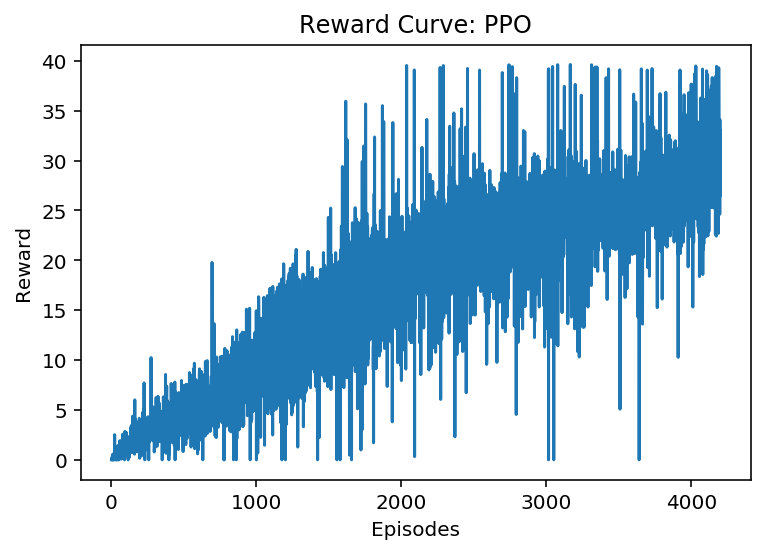

In [21]:
# plot the rewards curve
fig = plt.figure()
plt.plot(scores)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Reward Curve: PPO')
plt.savefig('images/reward_curve-ppo.png',dpi=300)
plt.show()

### 6. Watch the trained RL agent!

In [16]:
# uncomment this cell to load the trained policy for Reacher Unity environment
# load policy
policy =  torch.load(model_save_path+'ppo-reacher.policy',map_location=device)
agent = Agent(env)
agent.policy = policy

In [19]:
total_rewards = np.zeros(num_agents)

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
states = np.array(env_info.vector_observations)
while True:
    prediction = agent.policy.act(states)
    action  = prediction['a'].cpu().numpy()
    v = prediction['v'].detach().cpu().numpy()
    
    # send all actions to tne environment
    env_info = env.step(action)[brain_name]

    next_states = np.array(env_info.vector_observations)         # get next state (for each agent)
    rewards = np.array(env_info.rewards)                         # get reward (for each agent)
    terminals = np.array(env_info.local_done)                    # see if episode finished
    
    states=next_states
    total_rewards+= rewards
    
    if np.any(terminals):
        for i,terminal in enumerate(terminals):
            if terminal:
                eps_reward = total_rewards[i]
                break
        break

print ("Total episode reward:",eps_reward)

Total episode reward: 32.69999926909804
